In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.path import Path

from collections import deque
from itertools import izip

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

from skimage.measure import find_contours

sys.path.append('/home/yuncong/Brain/preprocess/morphsnakes')
import morphsnakes

from shapely.geometry import Polygon

from enum import Enum

class PolygonType(Enum):
    CLOSED = 'closed'
    OPEN = 'open'
    TEXTURE = 'textured'
    TEXTURE_WITH_CONTOUR = 'texture with contour'
    DIRECTION = 'directionality'
    
from itertools import chain

from skimage.morphology import binary_closing, disk, binary_dilation, binary_erosion, remove_small_holes
from skimage.measure import grid_points_in_poly, subdivide_polygon, approximate_polygon

In [20]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'
scoremaps_rootdir = '/home/yuncong/csd395/CSHL_scoremaps_lossless/'
# autoAnnotations_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_autoAnnotations_snake'
autoAnnotations_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_data_labelings_losslessAlignCropped/'
# autoAnnotationViz_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_autoAnnotationsViz_snake'

In [3]:
def find_contour_points(labelmap):
    '''
    return is (x,y)
    '''

    regions = regionprops(labelmap)

    contour_points = {}

    for r in regions:

        (min_row, min_col, max_row, max_col) = r.bbox

        padded = np.pad(r.filled_image, ((5,5),(5,5)), mode='constant', constant_values=0)

        contours = find_contours(padded, .5, fully_connected='high')
        contours = [cnt.astype(np.int) for cnt in contours if len(cnt) > 10]
        if len(contours) > 0:
#             if len(contours) > 1:
#                 sys.stderr.write('%d: region has more than one part\n' % r.label)
                
            contours = sorted(contours, key=lambda c: len(c), reverse=True)
            contours_list = [c-(5,5) for c in contours]
            contour_points[r.label] = sorted([c[np.arange(0, c.shape[0], 10)][:, ::-1] + (min_col, min_row) 
                                for c in contours_list], key=lambda c: len(c), reverse=True)
            
        elif len(contours) == 0:
#             sys.stderr.write('no contour is found\n')
            continue

    #         viz = np.zeros_like(r.filled_image)
    #         viz[pts_sampled[:,0], pts_sampled[:,1]] = 1
    #         plt.imshow(viz, cmap=plt.cm.gray);
    #         plt.show();
        
    return contour_points

In [4]:
# plt.imshow(test_volume_atlas_projected[..., 40])

In [58]:
def show_contours(cnts, bg, title):
    viz = bg.copy()
    for cnt in cnts:
        for c in cnt:
            cv2.circle(viz, tuple(c.astype(np.int)), 1, (0,255,0), -1)
        cv2.polylines(viz, [cnt.astype(np.int)], True, (0,255,0), 2)
        
    plt.figure(figsize=(10,10));
    plt.imshow(viz);
#     plt.title(title);
    plt.axis('off');
    plt.show();
    
def show_levelset(levelset, bg, title):
    viz = bg.copy()
    cnts = find_contours(levelset, .5)
    for cnt in cnts:
        for c in cnt[:,::-1]:
            cv2.circle(viz, tuple(c.astype(np.int)), 1, (0,255,0), -1)
    plt.figure(figsize=(10,10));
    plt.imshow(viz);
#     plt.title(title);
    plt.axis('off');
    plt.show();
    
# http://deparkes.co.uk/2015/02/01/find-concave-hull-python/
# http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/

from shapely.ops import cascaded_union, polygonize
from shapely.geometry import MultiLineString
from scipy.spatial import Delaunay
import numpy as np

def alpha_shape(coords, alphas):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    
    tri = Delaunay(coords)
    
    pa = coords[tri.vertices[:,0]]
    pb = coords[tri.vertices[:,1]]
    pc = coords[tri.vertices[:,2]]
    
    a = np.sqrt(np.sum((pa - pb)**2, axis=1))
    b = np.sqrt(np.sum((pb - pc)**2, axis=1))
    c = np.sqrt(np.sum((pc - pa)**2, axis=1))
    s = (a + b + c)/2.
    area = np.sqrt(s*(s-a)*(s-b)*(s-c))
    circum_r = a*b*c/(4.0*area)
        
    geoms = []
        
    for al in alphas:
        edges = tri.vertices[circum_r < 1.0 / al]

        edge_points = []
        for ia, ib, ic in edges:
            edge_points.append(coords[ [ia, ib] ])
            edge_points.append(coords[ [ib, ic] ])
            edge_points.append(coords[ [ic, ia] ])

        m = MultiLineString(edge_points)
        triangles = list(polygonize(m))
        r = cascaded_union(triangles)
        
        geoms.append(r)

        
#     edges = tri.vertices[circum_r < 1.0/alpha]

# # slightly slower than below
# #     edge_points = list(chain(*[[coords[ [ia, ib] ], coords[ [ib, ic] ], coords[ [ic, ia] ]]
# #                    for ia, ib, ic in edges]))
    
#     edge_points = []
#     for ia, ib, ic in edges:
#         edge_points.append(coords[ [ia, ib] ])
#         edge_points.append(coords[ [ib, ic] ])
#         edge_points.append(coords[ [ic, ia] ])

#     m = MultiLineString(edge_points)
#     triangles = list(polygonize(m))
#     r = cascaded_union(triangles)
    
    return geoms

def less(center):
    def less_helper(a, b):
        if (a[0] - center[0] >= 0 and b[0] - center[0] < 0):
            return 1;
        if (a[0] - center[0] < 0 and b[0] - center[0] >= 0):
            return -1;
        if (a[0] - center[0] == 0 and b[0] - center[0] == 0):
            if (a[1] - center[1] >= 0 or b[1] - center[1] >= 0):
                return 2*int(a[1] > b[1]) - 1;
            return 2*int(b[1] > a[1]) - 1

        # compute the cross product of vectors (center -> a) x (center -> b)
        det = (a[0] - center[0]) * (b[1] - center[1]) - (b[0] - center[0]) * (a[1] - center[1])
        if (det < 0):
            return 1;
        if (det > 0):
            return -1;

        # points a and b are on the same line from the center
        # check which point is closer to the center
        d1 = (a[0] - center[0]) * (a[0] - center[0]) + (a[1] - center[1]) * (a[1] - center[1])
        d2 = (b[0] - center[0]) * (b[0] - center[0]) + (b[1] - center[1]) * (b[1] - center[1])
        return 2*int(d1 > d2) - 1
    
    return less_helper

def sort_vertices_counterclockwise(cnt):
    # http://stackoverflow.com/a/6989383
    center = cnt.mean(axis=0)
    return sorted(cnt, cmp=less(center))


def contour_to_concave_hull(cnt, levelset, alphas):
    
    xmin, ymin = cnt.min(axis=0)
    xmax, ymax = cnt.max(axis=0)
    
#     if levelset is None:
    
#         h, w = (ymax-ymin+1, xmax-xmin+1)
#         inside_ys, inside_xs = np.where(grid_points_in_poly((h, w), cnt[:, ::-1]-(ymin,xmin))) 
#         n = inside_ys.size
#         random_indices = np.random.choice(range(n), min(5000, n), replace=False)
#         inside_points = np.c_[inside_xs[random_indices], inside_ys[random_indices]] + (xmin, ymin)

#     else:
        
    xs, ys = np.meshgrid(np.arange(xmin, xmax+1), np.arange(ymin, ymax+1))
    gridpoints = np.c_[xs.flat, ys.flat]
    inside_indices = np.where(levelset[gridpoints[:,1], gridpoints[:,0]] > 0)[0]
    n = inside_indices.size
    random_indices = np.random.choice(range(n), min(3000, n), replace=False)
    inside_points = gridpoints[inside_indices[random_indices]]
        

    geoms = alpha_shape(inside_points, alphas)
    
    base_area = np.sum(levelset)
    errs = np.array([(r.area if r.type == 'Polygon' else max([rr.area for rr in r])) - base_area for r in geoms])
    
#     plt.plot(errs);
#     plt.xticks(range(len(errs)), alphas);
#     plt.show();
    
#     plt.plot(np.abs(errs));
#     plt.xticks(range(len(errs)), alphas);
#     plt.show();
    
    c = np.argmin(np.abs(errs))
    r = geoms[c]
    
#     num_comps = np.array([1 if r.type == 'Polygon' else len(r) for r in geoms])
#     n = num_comps[-1]
#     while True:
#         c = np.min(np.where((num_comps == n) & (errs > 0)))
#         if errs[c] < 1e5:
#             break
#         n += 1
    
    if r.type == 'Polygon':
        concave_hull = r
    else:
        concave_hull = r[np.argmax([rr.area for rr in r])]
    
    # the heuristic rule here is:
    # merge two parts into one if the loss of including extraneous area is not larger 
    # than the loss of sacrificing all parts other than the largest one
    
    if not hasattr(concave_hull, 'exterior'):
        sys.stderr.write('No concave hull produced.\n')
        return None

    if concave_hull.exterior.length < 20 * 3:
        point_interval = concave_hull.exterior.length / 4
    else:
        point_interval = 20
    new_cnt_subsampled = np.array([concave_hull.exterior.interpolate(r, normalized=True).coords[:][0] 
                         for r in np.arange(0, 1, point_interval/concave_hull.exterior.length)], 
               dtype=np.int)

    return new_cnt_subsampled, alphas[c]

In [ ]:
# import time
# t = time.time()
# p = alpha_shape(new_cnt_subsampled, alpha=.01)
# print time.time() - t

# p

# init_cnt = init_cnts[l]
# init_cnt = contour_to_concave_hull(init_cnt, alpha=.1)

# plt.scatter(init_cnts[l][:,0], init_cnts[l][:,1])
# plt.scatter(init_cnt[:,0], init_cnt[:,1], c='g')
# plt.axis('equal')

In [45]:
stack = 'MD585'

autoAnnotationViz_dir = autoAnnotationViz_rootdir + '/' + stack
if not os.path.exists(autoAnnotationViz_dir):
    os.makedirs(autoAnnotationViz_dir)

first_bs_sec, last_bs_sec = section_range_lookup[stack]
first_detect_sec, last_detect_sec = detect_bbox_range_lookup[stack]

dm = DataManager(stack=stack)

# labels_to_detect = set(['5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL', 
#                      '6N', 'Amb', 'R', 'Tz', 'Sol', 'RtTg', 'LRt', 'LC', 'AP', 'sp5'])

labels_to_detect = set(['5N', '7n', '7N', '12N', 'Pn', 'VLL', 
                     '6N', 'Amb', 'R', 'Tz', 'LRt', 'LC', 'AP', 'sp5'])

# section_contains_label = {}
# for sec in range(first_bs_sec, last_bs_sec+1):
#     dm = DataManager(stack=stack, section=sec)
#     try:
#         user, ts, _, res = dm.load_proposal_review_result('yuncong', 'latest', 'consolidated')
#         section_contains_label[sec] = set([lm['label'] for lm in res])
#     except:
#         pass

test_volume_atlas_projected = bp.unpack_ndarray_file(volume_dir + '/%(stack)s_volume_atlasProjected.bp'%{'stack':stack})
print test_volume_atlas_projected.shape

(volume_xmin, volume_xmax, volume_ymin, volume_ymax, volume_zmin, volume_zmax) = \
    np.loadtxt(os.path.join(volume_dir, 'volume_%(stack)s_scoreMap_limits.txt' % {'stack': stack}), dtype=np.int)
    
# labels = ['BackG', '5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL']
labels = ['BackG', '5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL', 
                     '6N', 'Amb', 'R', 'Tz', 'Sol', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

label_dict = dict([(l,i) for i, l in enumerate(labels)])


downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled
    
# build annotation volume
section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end


map_z_to_section = {}
for s in range(section_bs_begin, section_bs_end+1):
    for z in range(int(z_xy_ratio_downsampled*s) - volume_zmin, 
                   int(z_xy_ratio_downsampled*(s+1)) - volume_zmin + 1):
        map_z_to_section[z] = s

(445, 816, 438)
78 347


In [7]:
dm = DataManager(stack=stack)

In [8]:
def pad_scoremap(stack, sec, l):
    
    scoremaps_dir = os.path.join(scoremaps_rootdir, stack, '%04d'%sec)
    
    try:
        scoremap_whole = bp.unpack_ndarray_file(os.path.join(scoremaps_dir, 
                                                   '%(stack)s_%(sec)04d_roi1_denseScoreMapLossless_%(label)s.bp' % \
                                                   {'stack': stack, 'sec': sec, 'label': l}))
    except:
        sys.stderr.write('No scoremap of %s exists\n' % (l))
        return None


    dataset = stack + '_' + '%04d'%sec + '_roi1'

    interpolation_xmin, interpolation_xmax, \
    interpolation_ymin, interpolation_ymax = np.loadtxt(os.path.join(scoremaps_dir, 
                                                                     '%(dataset)s_denseScoreMapLossless_%(label)s_interpBox.txt' % \
                                    {'dataset': dataset, 'label': l})).astype(np.int)

    dense_scoremap_lossless = np.zeros((dm.image_height, dm.image_width), np.float32)
    dense_scoremap_lossless[interpolation_ymin:interpolation_ymax+1,
                            interpolation_xmin:interpolation_xmax+1] = scoremap_whole

    return dense_scoremap_lossless

In [62]:
ngbr = 2
sss = np.empty((2*ngbr,), np.int)
sss[1::2] = -np.arange(1, ngbr+1)
sss[::2] = np.arange(1, ngbr+1)

init_cnts_allSecs = {}

for sec in range(first_detect_sec, last_detect_sec+1):
    
    autoAnnotations_dir = autoAnnotations_rootdir + '/' + stack + '/' + '%04d'%sec
    if not os.path.exists(autoAnnotations_dir):
        os.makedirs(autoAnnotations_dir)

    print sec
    
    #########################
        
    z = int(z_xy_ratio_downsampled*sec) - volume_zmin
    
    projected_annotation_labelmap = test_volume_atlas_projected[..., z]
    
    init_cnts = find_contour_points(projected_annotation_labelmap) # downsampled 16
    init_cnts = dict([(labels[label_ind], (cnts[0]+(volume_xmin, volume_ymin))*2) 
                      for label_ind, cnts in init_cnts.iteritems()])
        
    Ls = []
    for ss in sss:
        sec2 = sec + ss
        z2 = int(z_xy_ratio_downsampled*sec2) - volume_zmin
        if z2 >= test_volume_atlas_projected.shape[2]:
            continue
        if z2 < 0:
            continue
        
        init_cnts2 = find_contour_points(test_volume_atlas_projected[..., z2]) # downsampled 16
        init_cnts2 = dict([(labels[label_ind], (cnts[0]+(volume_xmin, volume_ymin))*2) 
                          for label_ind, cnts in init_cnts2.iteritems()])
        Ls.append(init_cnts2)
        
    for ll in Ls:
        for l, c in ll.iteritems():
            if l not in init_cnts:
                init_cnts[l] = c
                
    init_cnts_allSecs[sec] = init_cnts

132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292


In [24]:
import time

In [59]:
from collections import defaultdict

In [60]:
alpha_stats = defaultdict(list)

In [ ]:
# for sec in range(first_detect_sec, last_detect_sec+1):
# for sec in range(first_detect_sec, first_detect_sec+10):
# for sec in range(174, last_detect_sec+1):
for sec in SECTIONS if SECTIONS is not None else range(254, last_detect_sec+1):
# for sec in [157]:
    
    t = time.time()
    
    autoAnnotations_dir = autoAnnotations_rootdir + '/' + stack + '/' + '%04d'%sec
    if not os.path.exists(autoAnnotations_dir):
        os.makedirs(autoAnnotations_dir)
    
    dm.set_slice(sec)
    dm._load_image(versions=['rgb-jpg'], force_reload=True)
    cropped_img = dm.image_rgb_jpg[::8, ::8]
        
    sys.stderr.write('load image %f s\n' % (time.time() - t))
        
    print '\n'
    print sec
    
    #########################
        
    init_cnts = init_cnts_allSecs[sec]

    labels_exist = set(init_cnts.keys())
    
    valid_labels = labels_to_detect & labels_exist
    print valid_labels
    
    if len(valid_labels) == 0:
        sys.stderr.write('No valid labels exist.\n')
        continue

    new_res = []
    
    for l in valid_labels if SEE is None else SEE:
#     for l in ['7N']:
        
        print l
        
        t = time.time()
        
        dense_scoremap_lossless = pad_scoremap(stack, sec, l)
        
        if dense_scoremap_lossless is None:
            dense_scoremap_lossless = np.zeros((dm.image_height, dm.image_width), np.float32)
        
        scoremap0 = dense_scoremap_lossless[::8, ::8]
        
        scoremap = scoremap0.copy()
        
#         dense_scoremap_lossless_others = {}
#         for ll in labels_to_detect:
#             m = pad_scoremap(stack, sec, ll)
#             if m is not None:
#                 dense_scoremap_lossless_others[ll] = m[::8, ::8]
        
        complement = {'LRt': ['7N'],
                     '5N': ['7N'],
                     'Pn': ['Amb', 'LC', 'SuVe'],
                     'Tz': ['VLL'],
                     '12N': ['7N'],
                     'R': ['7N'],
                      'LC': ['LRt'],
                     'VLL': ['Pn', 'Tz', 'LC', 'LRt'],
                     '7N': ['6N', 'LRt', 'LC'],
                     'Sol': ['Pn']}
        
        def augment_scoremap(ll):
            global scoremap
            m = pad_scoremap(stack, sec, ll)
            if m is not None:
                scoremap = np.maximum(scoremap, m[::8, ::8])
        
        if l in complement:
            for ll in complement[l]:
                augment_scoremap(ll)
            if l == 'Pn' and 'VLL' not in valid_labels:
                augment_scoremap('VLL')
            if l == 'VLL' and 'Pn' not in valid_labels:
                augment_scoremap('Pn')
                    
        sys.stderr.write('load scoremap %f s\n' % (time.time() - t))
                    
        t = time.time()
        
        scoremap_height, scoremap_width = scoremap.shape[:2]

        init_cnt = init_cnts[l]

        if len(init_cnt) < 3:
            sys.stderr.write('initial contour has less than 3 vertices. \n')
            continue
            
#         init_cnt = contour_to_concave_hull(init_cnt, levelset=None, alpha=.01)
        
#         init_cnt = approximate_polygon(init_cnt, 5).astype(np.int)
#         init_cnt = subdivide_polygon(init_cnt, 5).astype(np.int)
        
        init_cnt_xmin, init_cnt_ymin = init_cnt.min(axis=0)
        init_cnt_xmax, init_cnt_ymax = init_cnt.max(axis=0)
        init_cnt_height, init_cnt_width = (init_cnt_ymax - init_cnt_ymin + 1, init_cnt_xmax - init_cnt_xmin + 1)
        init_cnt_cx, init_cnt_cy = np.mean(init_cnt, axis=0)
        
#         in_grid = grid_points_in_poly((init_cnt_height, init_cnt_width), init_cnt - (init_cnt_xmin, init_cnt_ymin))
        
        init_cnt_poly = Path(init_cnt)
        init_cnt_bbox_xs, init_cnt_bbox_ys = np.meshgrid(range(init_cnt_xmin, init_cnt_xmax+1), 
                                                         range(init_cnt_ymin, init_cnt_ymax+1))
        grid_points = np.c_[init_cnt_bbox_xs.flat, init_cnt_bbox_ys.flat]
        is_inside = init_cnt_poly.contains_points(grid_points)
        inside_points = grid_points[is_inside]
        
        shift_best = np.array((0,0))
        score_max = 0
        for xshift in range(-200, 200, 10):
            for yshift in range(-200, 200, 10):
                shifted_ys = inside_points[:,1] + int(yshift)
                shifted_xs = inside_points[:,0] + int(xshift)
                valid = (shifted_ys >= 0) & (shifted_ys < scoremap_height-1) & (shifted_xs >= 0) & (shifted_xs < scoremap_width-1)
                shifted_ys = shifted_ys[valid]
                shifted_xs = shifted_xs[valid]
                score = scoremap0[shifted_ys, shifted_xs].mean()
                if score_max < score:
                    score_max = score
                    shift_best = np.array([int(xshift), int(yshift)])
        
        print 'initial shift', shift_best, score_max
                
        if l == 'RtTg':
            shift_best = (0, 0)
        
#         init_cnt = init_cnt + shift_best
        init_cnt_xmin = max(init_cnt_xmin + shift_best[0], 0)
        init_cnt_ymin = max(init_cnt_ymin + shift_best[1], 0)
        init_cnt_xmax = min(init_cnt_xmax + shift_best[0], scoremap_width-1)
        init_cnt_ymax = min(init_cnt_ymax + shift_best[1], scoremap_height-1)
        
#         init_cnt_cx += shift_best[0]
#         init_cnt_cy += shift_best[1]
        inside_points += shift_best
        inside_points = inside_points[(inside_points[:,0] > init_cnt_xmin) & \
                                      (inside_points[:,0] < init_cnt_xmax) & \
                                      (inside_points[:,1] > init_cnt_ymin) & \
                                      (inside_points[:,1] < init_cnt_ymax)]
        
        sys.stderr.write('initial shift %f s\n' % (time.time() - t))
        
        
        roi_margin = max(200, (400-min(init_cnt_height, init_cnt_width))/2)
        # should be set to the largest landmark diameter (so that it is ok even if contour is placed at the end of it)
        
        roi_xmin, roi_ymin = (max(0, init_cnt_xmin - roi_margin), max(0, init_cnt_ymin - roi_margin))
        roi_xmax, roi_ymax = (min(scoremap_width-1, init_cnt_xmax + roi_margin), min(scoremap_height-1, init_cnt_ymax + roi_margin))
        roi_height, roi_width = (roi_ymax + 1 - roi_ymin, roi_xmax + 1 - roi_xmin)
                
        inside_points_inroi = inside_points - (roi_xmin, roi_ymin)
        
#         print 'init_cnt', init_cnt_xmin, init_cnt_ymin, init_cnt_xmax, init_cnt_ymax
#         print 'inside_points mins', inside_points.min(axis=0)
#         print 'inside_points maxs', inside_points.max(axis=0)
#         print 'inside_points_inroi mins', inside_points_inroi.min(axis=0)
#         print 'inside_points_inroi maxs', inside_points_inroi.max(axis=0)
#         print roi_xmin, roi_ymin, roi_xmax, roi_ymax, roi_width, roi_height
        
        scoremap_roi = scoremap[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1] 
                
        ######## landmark specific settings ########
        
        if l == '12N':
            score_thresh = 0.8
        elif l == 'sp5':
            score_thresh = 0.3
        elif l == 'LRt':
            score_thresh = 0.8
        elif l == '7N':
            score_thresh = 0.95
        elif l == 'Pn':
            score_thresh = 0.3
        elif l == 'Tz':
            score_thresh = 0.3
        elif l == 'R':
            score_thresh = 0.3
        elif l == 'LC':
            score_thresh = 0.3
        elif l == '5N':
            score_thresh = 0.3
        elif l == 'VLL':
            score_thresh = 0.3
        elif l == 'Sol':
            score_thresh = 0.3
        else:
            score_thresh = 0.8
            
        if l == 'sp5':
            smoothing = 1
        else:
            smoothing = 3
        
        if l == 'Tz':
            alphas = np.arange(.04, .16, .01)
        elif l == 'LC':
            alphas = np.arange(.08, .18, .01)
        elif l == 'Pn':
            alphas = np.arange(.03, .11, .01)
        # elif l == '7N':
        #     alphas = np.arange(.07, .12, .01)
#         if l == 'sp5':
#             alphas = np.arange(.20, 0.009, -.01) # using np.arange(.14, 0, -.01) results in weirdness
#         elif l == 'LRt':
#             alphas = np.arange(.20, 0.009, -.01)
# #             alphas = [.01]
        else:
            alphas = np.arange(.20, 0.009, -.01)
            
        #############################################
    
        scoremap_thresholded = scoremap_roi > score_thresh
        
        if SHOW:
            plt.figure(figsize=(10, 10));
            plt.imshow(scoremap_thresholded);
            plt.title('scoremap thresholded');
            plt.axis('off');
            plt.show();
        
        scoremap_thresholded_padded = np.zeros((roi_height + 100, roi_width + 100), np.bool)
        scoremap_thresholded_padded[50:-50, 50:-50] = scoremap_thresholded[:]
#         scoremap_thresholded_padded = binary_closing(scoremap_thresholded_padded, disk(10))

#         for _ in range(3):
#             scoremap_thresholded_padded = binary_dilation(scoremap_thresholded_padded, disk(3))
#         for _ in range(3):
#             scoremap_thresholded_padded = binary_erosion(scoremap_thresholded_padded, disk(3))

        scoremap_thresholded_padded = remove_small_holes(scoremap_thresholded_padded, 1000)
#         scoremap_thresholded_padded = remove_small_objects(scoremap_thresholded_padded, 100)
        scoremap_thresholded = scoremap_thresholded_padded[50:-50, 50:-50][:]

        if SHOW:        
            plt.figure(figsize=(10, 10));
            plt.imshow(scoremap_thresholded);
            plt.axis('off');
            plt.title('scoremap thresholded');
            plt.show();
            
        init_levelset = np.zeros((roi_height, roi_width))
        init_levelset[inside_points_inroi[:,1], inside_points_inroi[:,0]] = 1.
        
        t = time.time()
        
        msnake = morphsnakes.MorphACWE(scoremap_thresholded.astype(np.float), smoothing=smoothing, lambda1=1., lambda2=1.)
        
        msnake.levelset = init_levelset.copy()
        # levelset values are either 1.0 or 0.0

#         scoremap_layer_viz = img_as_ubyte(plt.cm.hot(scoremap_thresholded.astype(np.float))[..., :3])

        scoremap_roi2 = scoremap_roi.copy()
        scoremap_roi2[scoremap_roi > 1.] = 1.
        scoremap_layer_viz = img_as_ubyte(plt.cm.hot(scoremap_roi2)[..., :3])
        scoremap_viz = img_as_ubyte(alpha_blending(scoremap_layer_viz,
                                                   cropped_img[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1],
                                                   .3, 1))[..., :3]

#         plt.figure(figsize=(10,10));
#         plt.imshow(scoremap_roi);
#         plt.title('scoremap');
#         plt.show();
        
#         plt.figure(figsize=(10,10));
#         plt.imshow(scoremap_viz);
#         plt.title('scoremap thresholded');
#         plt.show();
        
        dq = deque([None, None])
        for i in range(1000): 
            
            # at stable stage, the levelset (thus contour) will oscilate, 
            # so instead of comparing to previous levelset, must compare to the one before the previous
            oneBefore_levelset = dq.popleft()
            
            if i > 10:
#                 print np.count_nonzero(msnake.levelset - oneBefore_levelset)
                if np.count_nonzero(msnake.levelset - oneBefore_levelset) < 3:
                    break

            dq.append(msnake.levelset)
        
            msnake.step()
            
            if SHOW:
                if i % 50 == 0:
                    show_levelset(msnake.levelset, scoremap_viz, 'iteration %d' % i)

        if SHOW:
            show_levelset(msnake.levelset, scoremap_viz, 'iteration %d' % i)

        # in the final levelset, inside could be 0. or 1., hard to say        
        edge_arr = np.r_[msnake.levelset[:,0], msnake.levelset[:,-1], msnake.levelset[0], msnake.levelset[-1]]        
        pos_edge_num = np.count_nonzero(edge_arr)
        bool_arr = msnake.levelset.astype(np.bool)
        
        if pos_edge_num < len(edge_arr) - pos_edge_num:
            # inside is 1.
            mean_inside_score = scoremap_roi[bool_arr].mean()
        else:
            # inside is 0.
            mean_inside_score = scoremap_roi[~bool_arr].mean()
            msnake.levelset = 1. - msnake.levelset
        
        # after this, all inside pixels have value 1.
            
        print 'mean inside score:', mean_inside_score
        print 'area:', np.count_nonzero(bool_arr)
        print 'snake iteration:', i
        
        if mean_inside_score < .3:
            continue
        
        sys.stderr.write('snake completes %f s\n' % (time.time() - t))

#         m = binary_closing(msnake.levelset, disk(20))
#         plt.figure(figsize=(10,10));
#         plt.imshow(m);
#         plt.show();
        
        t = time.time()
    
        new_cnts = find_contours(msnake.levelset, 0.5)
        new_cnts = [c[:, ::-1] for c in new_cnts]
#         cnt_is_dense = True
        
#         if len(new_cnts) == 1:
#             new_cnt = new_cnts[0]
        if len(new_cnts) == 0:
            sys.stderr.write('No contour detected from snake levelset.\n')
            continue

        all_cnt_points = np.concatenate(new_cnts)
        
        new_cnt_subsampled, auto_alpha = contour_to_concave_hull(all_cnt_points.astype(np.int), levelset=msnake.levelset, alphas=alphas)

        alpha_stats[l].append(auto_alpha)
        
        if new_cnt_subsampled is None:
            continue
    
        area_lowerlim = 1000
        area = Polygon(new_cnt_subsampled).area
        if area < area_lowerlim:
            sys.stderr.write('Concave hull area %d is too small.\n' % area)
            continue

        if SHOW:
            show_contours([new_cnt_subsampled], scoremap_viz, 'concave hull')
#             show_contours([new_cnt_subsampled, cropped_img[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1], 'concave hull')

        new_cnt_subsampled = new_cnt_subsampled + (roi_xmin, roi_ymin)
        
        
        sys.stderr.write('concave hull finishes %f s\n' % (time.time() - t))

        
        new_lm = {}
        new_lm['label'] = l
        new_lm['vertices'] = new_cnt_subsampled.astype(np.int) * 8
        new_lm['labelPos'] = new_lm['vertices'].mean(axis=0)
        new_lm['refVertices'] = np.array(init_cnt).copy() * 8
        new_lm['subtype'] = PolygonType.CLOSED
            
        new_res.append(new_lm)
        
    ######################################
    
    if not SHOW:
    
        timestamp = datetime.datetime.now().strftime("%m%d%Y%H%M%S")

        autoAnnotation_filepath = autoAnnotations_dir + '/%(stack)s_%(sec)04d_autoAnnotate_%(timestamp)s_consolidated.pkl' % \
                            {'stack': stack, 'sec': sec, 'timestamp': timestamp}

        pickle.dump(new_res, open(autoAnnotation_filepath, 'w'))   
        
    ######################################
    
#     viz = cropped_img.copy()
    
#     for l in valid_labels:
#         ref_cnt = init_cnts[l].astype(np.int)
#         for xy in ref_cnt:
#             cv2.circle(viz, tuple(xy), 3, (0,255,0), -1)
            
#     for lm in new_res:

#     # for pt in init_cnt:
#     #     cv2.circle(viz, tuple(pt), 2, (0,255,0,255), -1)

# #         ref_cnt = lm['refVertices'].astype(np.int)
# #         for xy in ref_cnt:
# #             cv2.circle(viz, tuple(xy), 3, (0,255,0), -1)

#         new_cnt = np.array(lm['vertices'])/8
                
#         for xy in new_cnt:
#             cv2.circle(viz, tuple(xy), 5, (255,0,0), -1)
#         cv2.polylines(viz, [new_cnt.astype(np.int)], True, (255,0,0), 2)

# #         if sec in section_contains_label and lm['label'] in section_contains_label[sec]:
# #             dm = DataManager(stack=stack, section=sec)
# #             user, ts, _, res = dm.load_proposal_review_result('yuncong', 'latest', 'consolidated')
# #             manual_cnt = [x['vertices'] for x in res if x['label'] == lm['label']][0]
# #             manual_cnt = np.array(manual_cnt)/8

# #             for xy in manual_cnt.astype(np.int):
# #                 cv2.circle(viz, tuple(xy), 3, (0,0,255), -1)
# #             cv2.polylines(viz, [manual_cnt.astype(np.int)], True, (0,0,255), 2)


#         lx, ly = np.array(lm['labelPos'])
#         cv2.putText(viz, lm['label'], (int(lx)-10, int(ly)+10), cv2.FONT_HERSHEY_DUPLEX, 1, ((0,0,0)), 3)

#     if not SHOW:
#         cv2.imwrite(autoAnnotationViz_dir + '/%(stack)s_%(sec)04d_autoAnnotationViz.jpg' % \
#                     {'stack': stack, 'sec': sec}, viz[..., ::-1])

load image 4.027088 s
No scoremap of Tz exists
load scoremap 0.568237 s




254
set(['Tz', 'LC', '7n', 'sp5', '7N', 'Pn'])
Tz
initial shift

In [ ]:
if l == 'Tz':
    alphas = np.arange(.04, .16, .01)
elif l == 'LC':
    alphas = np.arange(.08, .18, .01)
elif l == 'Pn':
    alphas = np.arange(.03, .11, .01)
# elif l == '7N':
#     alphas = np.arange(.07, .12, .01)

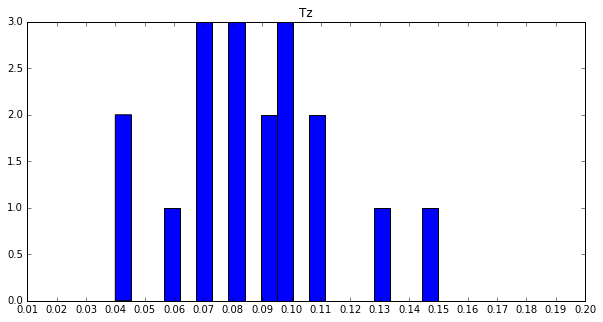

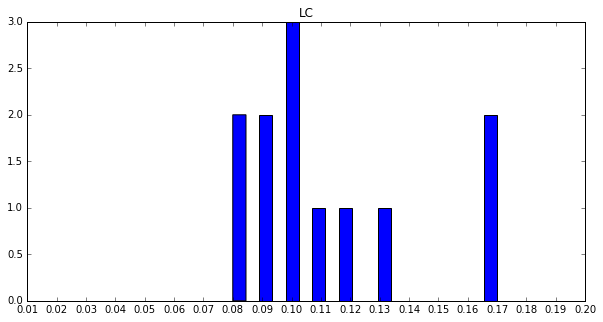

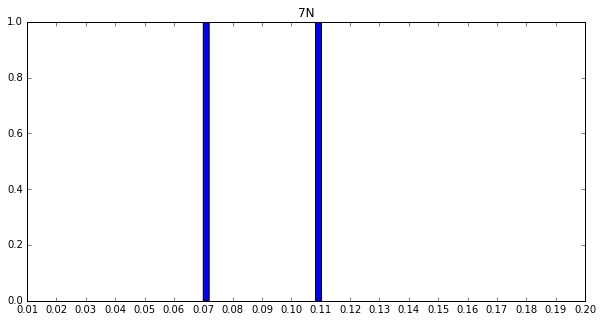

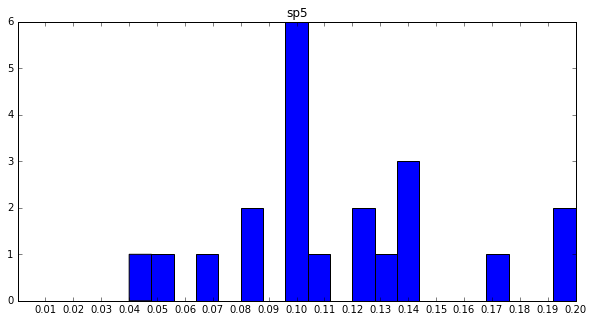

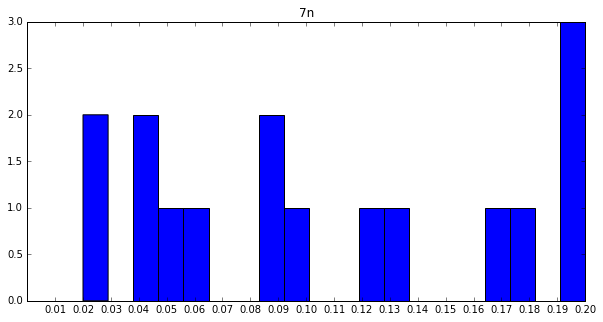

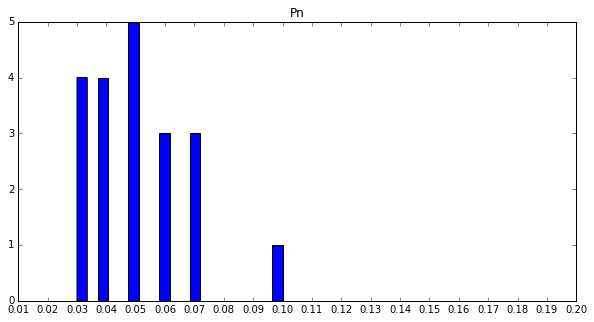

In [74]:
for l, q in alpha_stats.iteritems():
    plt.figure(figsize=(10,5))
    plt.title(l)
    plt.hist(q, bins=20)
    plt.xticks(alphas)
#     plt.xticks(range(len(alphas)), alphas)
    plt.show()

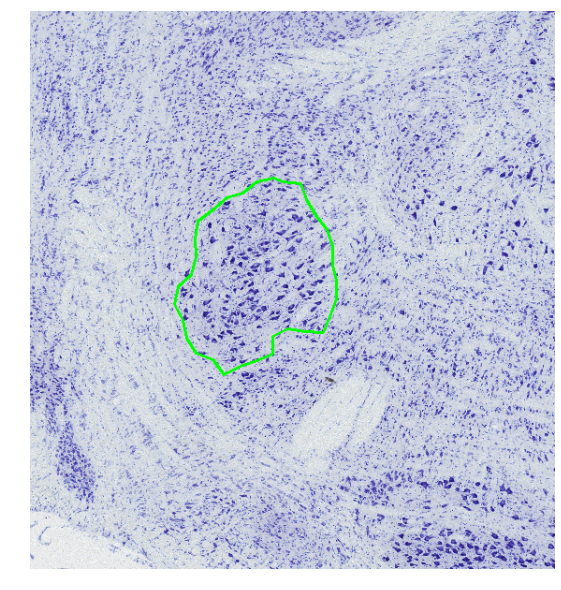

In [49]:
# For MICCAI 
show_contours([new_cnt_subsampled - (roi_xmin, roi_ymin)], 
              cropped_img[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1], 'concave hull')

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(20,20), sharex=True, sharey=True);
axes = axes.flatten()
for i, (l, sm) in enumerate(dense_scoremap_lossless_others.iteritems()):
    axes[i].imshow(sm[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1]);
    axes[i].set_title(l);
plt.show();

In [ ]:
# ISSUES:
# - if initial contour (shifted) does not cover some broken part of the hotness, 
# this part will never be considered no matter how hot it is

# - boundary inaccuracy should be improved by taking surrounding as negatives in a more pinpointy way.
# - the fact that one part is judged to be one class should  explain away its probability in other places: need a global model

In [37]:
SECTIONS = [144]

In [35]:
SHOW = True
SEE = ['5N']

In [55]:
SECTIONS = None

In [56]:
SHOW = False
SEE = None

In [ ]:
plt.figure(figsize=(15, 15));
plt.imshow(viz);

In [ ]:
cnt = all_cnt_points.astype(np.int)

xmin, ymin = cnt.min(axis=0)
xmax, ymax = cnt.max(axis=0)

xs, ys = np.meshgrid(np.arange(xmin, xmax+1), np.arange(ymin, ymax+1))
gridpoints = np.c_[xs.flat, ys.flat]
inside_indices = np.where(msnake.levelset[gridpoints[:,1], gridpoints[:,0]] > 0)[0]
n = inside_indices.size
random_indices = np.random.choice(range(n), min(5000, n), replace=False)
inside_points = gridpoints[inside_indices[random_indices]]
concave_hull = alpha_shape(inside_points, alphas=[.01])[0]
# print len(concave_hull)
print concave_hull.area
concave_hull

In [ ]:
cnt = all_cnt_points.astype(np.int)

xmin, ymin = cnt.min(axis=0)
xmax, ymax = cnt.max(axis=0)
h, w = (ymax-ymin+1, xmax-xmin+1)
inside_ys, inside_xs = np.where(grid_points_in_poly((h, w), cnt[:, ::-1]-(ymin,xmin))) 
n = inside_ys.size
random_indices = np.random.choice(range(n), min(1000, n), replace=False)
inside_points = np.c_[inside_xs[random_indices], inside_ys[random_indices]]
concave_hull = alpha_shape(inside_points, alpha=.6)
concave_hull

In [ ]:
new_cnt_subsampled, auto_alpha = contour_to_concave_hull(all_cnt_points.astype(np.int), msnake.levelset, alphas=[.01])
plt.scatter(all_cnt_points[::5,0], all_cnt_points[::5,1], c='g');
plt.scatter(new_cnt_subsampled[:,0], new_cnt_subsampled[:,1]);
plt.axis('equal');

In [ ]:
# For MICCAI paper (image, scoremap, atlas projected contours)

sec = 143

autoAnnotations_dir = autoAnnotations_rootdir + '/' + stack + '/' + '%04d'%sec
if not os.path.exists(autoAnnotations_dir):
    os.makedirs(autoAnnotations_dir)

dm = DataManager(stack=stack, section=sec)
dm._load_image(versions=['rgb-jpg'])
cropped_img = dm.image_rgb_jpg[::8, ::8]

scoremaps_dir = os.path.join(scoremaps_rootdir, stack, '%04d'%sec)

print '\n'
print sec

#########################

z_lowerlim = int(z_xy_ratio_downsampled*sec) - volume_zmin
z_nextsec = int(z_xy_ratio_downsampled*(sec+1)) - volume_zmin
z_previous = int(z_xy_ratio_downsampled*(sec-1)) - volume_zmin

projected_annotation_labelmap = test_volume_atlas_projected[..., z_lowerlim]

init_cnts = find_contour_points(projected_annotation_labelmap) # downsampled 16
init_cnts = dict([(labels[label_ind], (cnts[0]+(volume_xmin, volume_ymin))*2) 
                  for label_ind, cnts in init_cnts.iteritems()])

# This has problems because some lms can not be detected even if there are some of their pixels on the map
#     label_indices_exist = set(np.unique(projected_annotation_labelmap))

#     label_indices_exist = set(np.r_[np.unique(test_volume_atlas_projected[..., z_nextsec]),
#                                 np.unique(test_volume_atlas_projected[..., z_previous]), 
#                                 np.unique(projected_annotation_labelmap)])

#     labels_exist = set([labels[i] for i in label_indices_exist])

labels_exist = set(init_cnts.keys())

valid_labels = labels_to_detect & labels_exist
print valid_labels

# if len(valid_labels) == 0:
#     sys.stderr.write('No valid labels exist.\n')
#     continue

# new_res = []

l = '7n'

print l

# try:
scoremap_whole = bp.unpack_ndarray_file(os.path.join(scoremaps_dir, 
                                           '%(stack)s_%(sec)04d_roi1_denseScoreMapLossless_%(label)s.bp' % \
                                           {'stack': stack, 'sec': sec, 'label': l}))
# except:
#     sys.stderr.write('No scoremap of %s exists\n' % (l))
#     continue


dataset = stack + '_' + '%04d'%sec + '_roi1'

interpolation_xmin, interpolation_xmax, \
interpolation_ymin, interpolation_ymax = np.loadtxt(os.path.join(scoremaps_dir, 
                                                                 '%(dataset)s_denseScoreMapLossless_%(label)s_interpBox.txt' % \
                                {'dataset': dataset, 'label': l})).astype(np.int)

dense_scoremap_lossless = np.zeros((dm.image_height, dm.image_width), np.float32)
dense_scoremap_lossless[interpolation_ymin:interpolation_ymax+1,
                        interpolation_xmin:interpolation_xmax+1] = scoremap_whole

scoremap = dense_scoremap_lossless[::8, ::8]
scoremap_height, scoremap_width = scoremap.shape[:2]

scoremap_layer_viz = img_as_ubyte(plt.cm.hot(scoremap)[..., :3])
scoremap_viz = img_as_ubyte(alpha_blending(scoremap_layer_viz,
                                           cropped_img,
                                           .3, 1)[..., :3])

vertices = init_cnts[l]

#     for x,y in vertices:
#         cv2.circle(viz, (int(x), int(y)), 5, (0,0,255), -1)
cv2.polylines(scoremap_viz, [vertices.astype(np.int)], True, (255,0,0), 5)

#             lx, ly = np.array(ann['labelPos']) / downscale_factor
#             cv2.putText(viz, ann['label'], (int(lx)-10, int(ly)+10), 
#                         cv2.FONT_HERSHEY_DUPLEX, 1, ((0,0,0)), 2)

#                 label_texts.add(ann['label'])

display(scoremap_viz)